# Agenda
1. [What is Speaker Diarization and why do we need it?](#intro)
2. [Preliminaries](#preliminaries) <br>
    2.1 [Dataset overview](#dataset) <br>
    2.2 [How to evaluate a speaker diarization pipeline?](#metric) <br>
3. [A Deep Dive into Theory](#theory) <br>
    3.1 [General pipeline structure](#structure) <br>
    3.2 [Segmentation](#segmentation) <br>
    3.3 [Audio Embeddings](#embeddings) <br>
    3.4 [Clustering](#clustering) <br>
4. [Pyannote practice](#pyannote) <br>
    4.1 [Framework overview](#framework) <br>
    4.2 [Segmentation finetuning](#finetuning) <br>
5. [References](#references)
6. [Homework](#homework)

<a id='intro'></a>
# What is Speaker Diarization and why do we need it?

Speaker diarization is the process of automatically identifying and segmenting an audio recording into distinct speech segments, where each segment corresponds to a particular speaker. In simpler words, the goal is to answer the question: who spoke when? It involves analyzing the audio signal to detect changes in speaker identity, and then grouping together segments that belong to the same speaker.

Speaker diarization is a key component of conversation analysis tools and can often be coupled with Automatic Speech Recognition (ASR) or Speech Emotion Recognition (SER) to extract meaningful information from conversational content. Hence, speaker diarization provides important information when performing speech analysis that involves several speakers. <br> <br>
**Example without speaker diarization:** <br>
> Hello, and thank you for calling premier phone service. Please be aware that this call may be recorded for quality and training purposes. My name is Beth, and I will be assisting you today. How are you doing? Not too bad. How are you today? I'm doing well. Thank you. May I please have your name? My name is Blake.

**With speaker diarization:** <br>
> *[Speaker:0] -* Hello, and thank you for calling premier phone service. Please be aware that this call may be recorded for quality and training purposes. <br>
*[Speaker:0] -* My name is Beth, and I will be assisting you today. How are you doing? <br>
*[Speaker:1] -* Not too bad. How are you today? <br>
*[Speaker:0] -* I'm doing well. Thank you. May I please have your name? <br>
*[Speaker:1] -* My name is Blake.

![](https://docs.nvidia.com/nemo-framework/user-guide/latest/_images/asr_sd_diagram.png)
<br><br>

### Main Approaches
The speaker diarization task relates to answering the question: who spoke when? For such a problem, two main approaches can be considered:
- **Supervised approach / Classification problem:** a model is trained to recognize a finite number of speakers (i.e. classes). Thus, it is expected that it only works with speakers that were used among the training data.
- **Unsupervised approach / Clustering problem:** a model clusters audio segments according to the speaker based on extracted audio features. It is the most versatile approach since it can detect the number of speakers involved (number of clusters) and assign each voice segment to a specific cluster.
> **Explore**: Think about the use cases and limitations of those approaches.

In this lecture we will study the unsupervised approach, because it's more flexible.

<a id='preliminaries'></a>
# Preliminaries
In this chapter we will explore the dataset and evaluation metric for our task.
<a id='dataset'></a>
## Dataset overview

The AMI Corpus is a multi-modal dataset consisting of 100 hours of meeting recordings. Around two-thirds of the data was elicited using a scenario where the participants played different roles in a design team, taking a design project from kick-off to completion over a day. The rest consists of naturally occurring meetings in a range of domains. Detailed information can be found in the [documentation](https://groups.inf.ed.ac.uk/ami/corpus/overview.shtml) section.

In [46]:
%%capture
%pip install pyannote.audio

In [47]:
# this dataset would take approximately 11 GB of space
# %git clone https://github.com/pyannote/AMI-diarization-setup.git

# %cd ./AMI-diarization-setup/pyannote/
# On Windows, you will need git bash (and run this separately there) or WSL installed. Also, you will need wget there.
# Here is an instruction to install wget on windows for git bash: https://gist.github.com/evanwill/0207876c3243bbb6863e65ec5dc3f058
# !bash ./download_ami.sh
# %cd ../..

In [59]:
from pyannote.database import registry, FileFinder

registry.load_database("./pyannote/database.yml")
preprocessors = {"audio": FileFinder()}
dataset = registry.get_protocol('VoxConverse.SpeakerDiarization.finetune', preprocessors=preprocessors)

  warnings.warn(



'VoxConverse.SpeakerDiarization.finetune' found in /mnt/d/sound_processing/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.


The most common data annotations format for the speaker diarization task is RTTM.

**Rich Transcription Time Marked** (RTTM) files are space-delimited text files containing one turn per line, each line containing ten fields:
- Type — segment type; should always by SPEAKER.
- File ID — file name; basename of the recording minus extension (e.g., rec1_a).
- Channel ID — channel (1-indexed) that turn is on; should always be 1.
- Turn Onset — onset of turn in seconds from beginning of recording.
- Turn Duration — duration of turn in seconds.
- Orthography Field — should always by `<NA>`.
- Speaker Type — should always be `<NA>`.
- Speaker Name — name of speaker of turn.
- Confidence Score — system confidence (probability) that information is correct; should always be `<NA>`.
- Signal Lookahead Time — should always be `<NA>`.

SPEAKER abjxc 1 0.400 6.640 <NA> <NA> spk00 <NA> <NA>
SPEAKER abjxc 1 8.680 55.960 <NA> <NA> spk00 <NA> <NA>

...


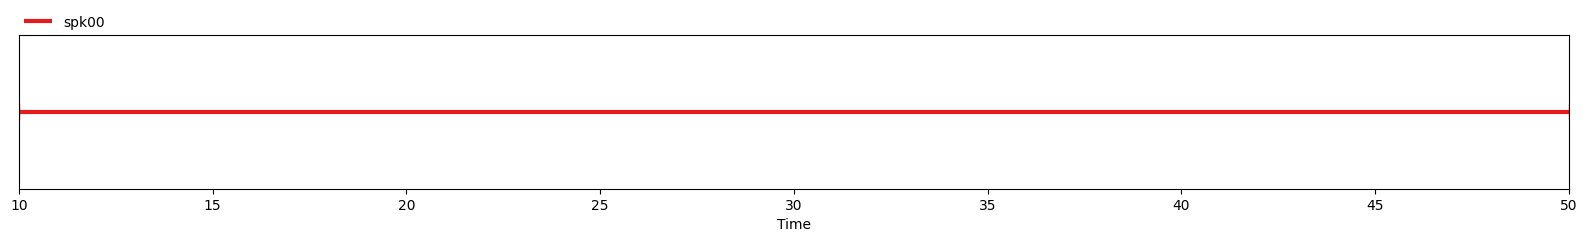

In [60]:
sample = next(dataset.train())
print('\n'.join(sample['annotation'].to_rttm().split('\n')[:10]) + '\n...')
sample['annotation']

In [61]:
sample.files()

<generator object ProtocolFile.files at 0x7efda9c68a50>

In [62]:
from pyannote.audio.utils.preview import listen
from pyannote.core import Segment

sample_segment = Segment(10, 50)
print(sample)
listen(sample, sample_segment)

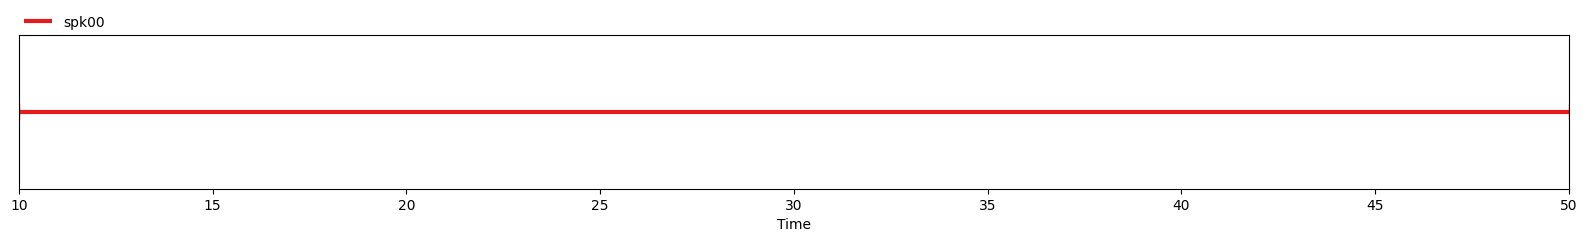

In [63]:
from pyannote.core import notebook

notebook.crop = sample_segment
sample['annotation']

<a id='metric'></a>
## How to evaluate a speaker diarization pipeline?

The standard metric for speaker diarization problem is the Diarization error rate: <br><br>
$$ DER= \frac{FalseAlarm+MissedDetection+Confusion}{Total} $$

- **False Alarm** - Speech segment predicted where there is no speaker (False positive from VAD model).
- **Missed Detection** - No speech detected where there is a speaker (False negative from VAD model).
- **Confusion** - Speech is in the wrong cluster (error from the clustering model).

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*08iCugqS9zesOJ5L0k5sFQ.png)

<a id='theory'></a>
# A Deep Dive into Theory

<a id='structure'></a>
## General pipeline structure

Early approaches for speaker diarization were based on Digital Signal Processing techniques and later on, based on statistical modeling (Hidden Markov Model, Gaussian Mixture, etc). Modern speaker diarization techniques rely on advanced deep learning and neural networks. In the context of unsupervised speaker diarization (which is the most common approach), the pipeline involves several subtasks to detect voice activity and segment audio into speech and non-speech segments and then clustering them according to the speaker. 

Pre-trained models and frameworks can be easily leveraged to perform speaker diarization with low error rates, and modern frameworks like [pyannote](https://github.com/pyannote/pyannote-audio/tree/develop) and [NeMo](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_diarization/intro.html) are flexible and can be tuned for many different use cases without having to finetune models. 

Our focus will be on pyannote, although both frameworks have similar solutions.

The typical SD pipeline structure:<br>
![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*clA5n1kPDuRvm9ztK0-Rpw.png)

- **Voice Activity Detection / Speaker Segmentation:** Segmenting the speech portions into smaller chunks where each chunk is hypothesized to contain speech from only one speaker or several speakers speaking simultaneously.
- **Audio Embedding:** Extracting meaningful features from the different voices using segments from the previous step.
- **Clustering:** Grouping these segments based on the speaker identity, such that all segments belonging to the same speaker are clustered together.

<a id='segmentation'></a>
## Segmentation

Although there are many standard approaches for the simpler version of the task — binary VAD(e.g. [classical ml approaches overview](https://speechprocessingbook.aalto.fi/Recognition/Voice_activity_detection.html), [unsupervised approach](https://www.researchgate.net/publication/255667085_A_simple_but_efficient_real-time_voice_activity_detection_algorithm)), all of them struggle with the case of simultaneously speaking speakers. So, in this case, we need a SOTA approach [presented](https://arxiv.org/pdf/2104.04045.pdf) in pyannote.

Instead of addressing voice activity detection, speaker change detection, and overlapped speech detection as three different tasks, the task is to train an end-to-end speaker segmentation model whose output encompasses the abovementioned sub-tasks. The task is modeled as a multi-label classification problem using permutation-invariant training. 
![](./images/image1.png)
Actual outputs of our model on two 5s excerpts from the conversation between two speakers. 
- Top row shows the reference annotation. 
- Middle row is the audio chunk ingested by the model. 
- Bottom row depicts the raw speaker activations, as returned by the model. <br>

Thanks to permutation-invariant training, notice how the blue speaker corresponds to the orange activation on the left and to the green one on the right.

$ y=\{ y_{1}, \cdots , y_{T} \}$ where $y_{t} \in \{0,1\}^{K_{\max }}$ and $ y_{t}^{k} = 1 $ if speaker $k$ is active at frame $t$ and $ y_{t}^{k} = 1 $ - otherwise. We may arbitrarily sort speakers by chronological order of their first activity but any permutation of the $K_{\max }$ dimensions is a valid representation of the reference segmentation. Therefore, the binary cross entropy loss function $L_{BCE }$ (classically used for such multi-label classification problems) has to be turned into a
permutation-invariant loss function $L$ by running over all possible permutations perm(y) of y over its $K_{\max }$ dimensions: <br>

$$ L(y, \hat{y}) = \min_{perm(y)} L_{BCE }(y, \hat{y})$$

<a id='embeddings'></a>
## Audio Embeddings

This step consists in extracting $K_{w}$ speaker embeddings for each window $w$: exactly one embedding per speaker who is active within the window $w$.
![](./images/image2.png)

Speaker embedding. 
- Top row: 5s audio chunk. 
- Middle row: two speakers are active according to the neural speaker segmentation model (the orange one and the blue one).
- Bottom row: the speaker embedding of the blue speaker is computed using only the blue audio signal, while the concatenation of orange audio signals is used to compute the speaker embedding of the orange speaker. No embedding is extracted for the green speaker as its probability never goes above θ segmentation threshold.

As depicted by they gray overlay, speakers may overlap partially within the considered window. To account for this possibility, the embedding of each speaker is computed from the concatenation of audio samples during which the particular speaker is active and other speakers are inactive. This could be called overlap-aware speaker embeddings.

Compared to the standard approach that consists in extracting exactly one speaker embedding using a short (typically 1 or 2 seconds) periodic window, the proposed speaker embeddings are expected to be more reliable for two main reasons:
- they are extracted from audio excerpts that only contain speech samples from one single speaker while the standard approach may extract speaker embeddings from a mixture of speakers (and non-speech);
- they are extracted from potentially longer audio excerpts (up to 5s in case a speaker speaks during the whole window w) while the standard approach is limited to 1 or 2 seconds.

The main drawback of this approach is that it depends on the upstream speaker segmentation model whose errors could lead to degraded speaker embeddings.

From a practical point of view, almost any available pre-trained embedding can be used in this step.

> **Explore**: Check [simple implementation](https://github.com/RF5/simple-speaker-embedding/tree/master) with [Generalized End-to-End Loss](https://arxiv.org/pdf/1710.10467.pdf) for speaker verification.


> **Explore**: Check [Self Supervised Representations Lecture](https://github.com/VSydorskyy/ucu_audio_processing_course/blob/main/Module_2/Lecture_4/Self_Supervised_Representations.ipynb).

<a id='clustering'></a>
## Clustering

The global agglomerative clustering step consists in clustering the resulting set of speaker embedding in order to assign each local speaker (from 5s segment) to a global cluster. 

Although spectral clustering and variational Bayesian hidden Markov models have been the prefered clustering techniques
in recent speaker diarization literature, the proposed pipeline relies on a classical agglomerative hierarchical clustering with centroid linkage (also known as the UPGMC algorithm). <br>

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)

> **Explore**: Check final clustering + diarization [step](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/asr/speaker_diarization/models.html) in NeMo


![](./images/image3.png)

The final step aims at aggregating the clustered local speaker segmentation into an actual speaker diarization output.
It can be summarized as follows:
1. estimating the instantaneous (i.e. for each frame f) number of speakers Kf , by summing the binary local speaker segmentation and averaging over overlapping windows;
2. estimating the instantaneous score of each cluster by summing the clustered local speaker segmentation over overlapping windows;
3. selecting the Kf clusters with highest instantaneous score and converting from discrete frame indices to the temporal domain;
4. filling within-speaker gaps shorter than a (usually short) predefined duration ∆.

<a id='pyannote'></a>
# Pyannote practice

pyannote.audio is an open-source toolkit written in Python for speaker diarization. Based on PyTorch machine learning framework, it comes with state-of-the-art pretrained models and pipelines, that can be further finetuned to your own data for even better performance.

<a id='framework'></a>
## Framework overview

> **Important**: Before runing following cells, accept conditions of those repos:
> - [PyAnnote Segmentation 3.0](https://huggingface.co/pyannote/segmentation-3.0);
> - [PyAnnote Speaker Dialization 3.1](https://huggingface.co/pyannote/speaker-diarization-3.1).

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [64]:
import torch
from pyannote.audio import Pipeline

pretrained_pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1", use_auth_token=True
).to(torch.device('cpu'))

In [65]:
from pyannote.metrics.diarization import DiarizationErrorRate
from tqdm.autonotebook import tqdm

metric = DiarizationErrorRate()

sample = list(dataset.test())[0]
sample["pretrained pipeline"] = pretrained_pipeline(sample)
metric(sample["annotation"], sample["pretrained pipeline"], uem=sample["annotated"])
print(f"The pretrained pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on sample.")

  std = sequences.std(dim=-1, correction=1)



The pretrained pipeline reaches a Diarization Error Rate (DER) of 11.2% on sample.


In [66]:
from pyannote.audio.utils.preview import listen
from pyannote.core import Segment

sample_segment = Segment(30, 120)
listen(sample, sample_segment)

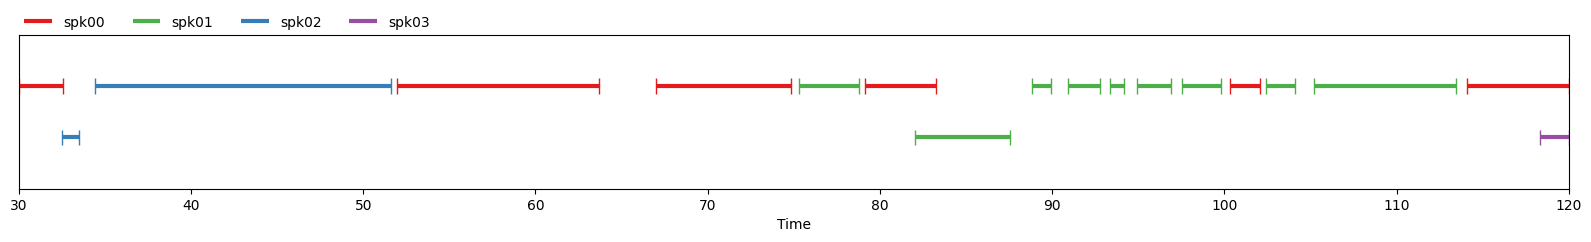

In [67]:
notebook.crop = sample_segment
sample["annotation"]

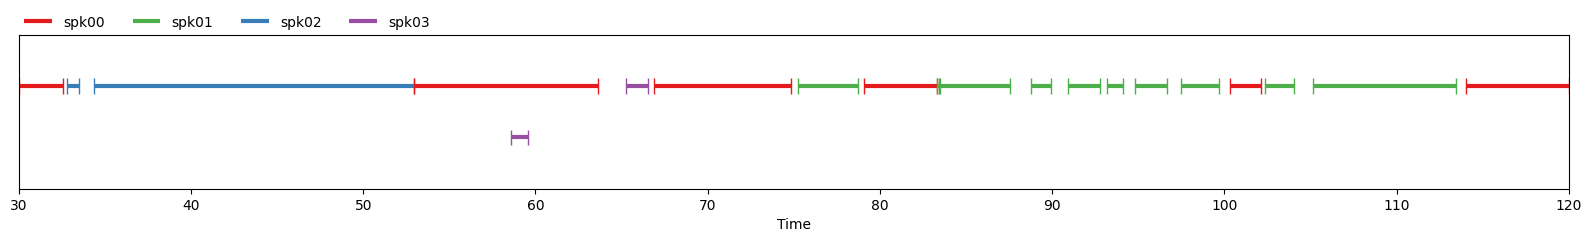

In [68]:
notebook.crop = sample_segment
sample["pretrained pipeline"]

In [69]:
from pyannote.metrics.diarization import DiarizationErrorRate
from tqdm.autonotebook import tqdm

metric = DiarizationErrorRate()

test_len = len(list(dataset.test()))

for file in tqdm(dataset.test(), total=test_len):
    file["pretrained pipeline"] = pretrained_pipeline(file)
    metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"])

print(f"The pretrained pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

  0%|          | 0/232 [00:00<?, ?it/s]

  warnings.warn(msg.format(key=key))



KeyboardInterrupt: 

### Pre-trained segmentation component

The first layer of a standard CNN performs a set of time-domain convolutions between the input waveform and some Finite Impulse Response (FIR) filters.

> **Explore**: Check the original SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET [paper](https://arxiv.org/pdf/1911.01255v1.pdf).

![](./images/image4.png)

In [ ]:
from pyannote.audio import Model
model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True).cuda()
model

PyanNet(
  (sincnet): SincNet(
    (wav_norm1d): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (conv1d): ModuleList(
      (0): Encoder(
        (filterbank): ParamSincFB()
      )
      (1): Conv1d(80, 60, kernel_size=(5,), stride=(1,))
      (2): Conv1d(60, 60, kernel_size=(5,), stride=(1,))
    )
    (pool1d): ModuleList(
      (0-2): 3 x MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (norm1d): ModuleList(
      (0): InstanceNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (1-2): 2 x InstanceNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
  )
  (lstm): LSTM(60, 128, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (classifier): Linear(in_features=128, out_features=7, bias=

### Pre-trained segmentation component

> **Important**: Before runing following cells, accept conditions of those repos:
> - [PyAnnote Embedding](https://huggingface.co/pyannote/embedding).

In [ ]:
model = Model.from_pretrained("pyannote/embedding", use_auth_token=True).cuda()
model

/home/robinhad/Projects/ucu_audio_processing_course/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/torch/pyannote/models--pyannote--embedding/snapshots/4db4899737a38b2d618bbd74350915aa10293cb2/pytorch_model.bin`
/home/robinhad/Projects/ucu_audio_processing_course/.venv/lib/python3.12/site-packages/pyannote/audio/core/model.py:692: UserWarning: Model has been trained with a task-dependent loss function. Set 'st

Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.6.0+cu124. Bad things might happen unless you revert torch to 1.x.
Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.6.0+cu124. Bad things might happen unless you revert torch to 1.x.


/home/robinhad/Projects/ucu_audio_processing_course/.venv/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['loss_func.W']


XVectorSincNet(
  (sincnet): SincNet(
    (wav_norm1d): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (conv1d): ModuleList(
      (0): Encoder(
        (filterbank): ParamSincFB()
      )
      (1): Conv1d(80, 60, kernel_size=(5,), stride=(1,))
      (2): Conv1d(60, 60, kernel_size=(5,), stride=(1,))
    )
    (pool1d): ModuleList(
      (0-2): 3 x MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (norm1d): ModuleList(
      (0): InstanceNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (1-2): 2 x InstanceNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
  )
  (tdnns): ModuleList(
    (0): Conv1d(60, 512, kernel_size=(5,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(2,))
    (4): Leaky

<a id='finetuning'></a>
## Segmentation finetuning

In [ ]:
from pyannote.audio import Model
model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True).cuda()

In [ ]:
from pyannote.audio.tasks import Segmentation
task = Segmentation(
    dataset, 
    duration=model.specifications.duration, 
    max_num_speakers=len(model.specifications.classes), 
    batch_size=32,
    num_workers=8, 
    loss="bce", 
    vad_loss="bce"
)

model.task = task
model.prepare_data()
model.setup()

Protocol AMI.SpeakerDiarization.only_words does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


/home/robinhad/Projects/ucu_audio_processing_course/.venv/lib/python3.12/site-packages/pyannote/audio/tasks/segmentation/speaker_diarization.py:176: UserWarning: `max_num_speakers` has been deprecated in favor of `max_speakers_per_chunk`.
  warnings.warn(
/home/robinhad/Projects/ucu_audio_processing_course/.venv/lib/python3.12/site-packages/pyannote/audio/tasks/segmentation/speaker_diarization.py:180: UserWarning: `loss` has been deprecated and has no effect.
  warnings.warn("`loss` has been deprecated and has no effect.")
/home/robinhad/Projects/ucu_audio_processing_course/.venv/lib/python3.12/site-packages/pyannote/database/protocol/protocol.py:140: UserWarning: Existing precomputed key "annotation" has been modified by a preprocessor.
  warnings.warn(msg.format(key=key))
/home/robinhad/Projects/ucu_audio_processing_course/.venv/lib/python3.12/site-packages/pyannote/audio/core/model.py:229: UserWarning: Model has been trained for a different task. For fine tuning or transfer learning

In [ ]:
from types import MethodType
from torch.optim import Adam
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)

# we use Adam optimizer with 1e-4 learning rate
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)

model.configure_optimizers = MethodType(configure_optimizers, model)

# we monitor diarization error rate on the validation set
# and use to keep the best checkpoint and stop early
monitor, direction = task.val_monitor
checkpoint = ModelCheckpoint(
    monitor=monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False,
)
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False,
)

callbacks = [RichProgressBar(), checkpoint, early_stopping]

# we train for at most 20 epochs (might be shorter in case of early stopping)
from pytorch_lightning import Trainer
trainer = Trainer(
    accelerator="gpu", 
    callbacks=callbacks, 
    max_epochs=20,
    gradient_clip_val=0.5
)

trainer.fit(model)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃ Mode  ┃       In sizes ┃                          Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ sincnet           │ SincNet          │ 42.6 K │ train │ [1, 1, 160000] │                       [1, 60, 589] │
│ 1 │ lstm              │ LSTM             │  1.4 M │ train │   [1, 589, 60] │  [[1, 589, 256], [[8, 1, 128], [8, │
│   │                   │                  │        │       │                │                          1, 128]]] │
│ 2 │ linear            │ ModuleList       │ 49.4 K │ train │              ? │                                  ? │
│ 3 │ classifier        │ Linear           │    387 │ train │  [1, 589, 128] │                        [1, 589, 3] │
│ 4 │ activation        │ Sigmoid          │      0 │ train │    [1, 589, 3] │                        [1, 589, 3] │
│ 5 │ validation_metric │ MetricCollection │      0 │ train │              ? │                                  ? │
└───┴───────────────────┴──────────────────┴────────┴───────┴────────────────┴────────────────────────────────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 27                                                                                          
Modules in eval mode: 0

Output()

/home/robinhad/Projects/ucu_audio_processing_course/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/
data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when 
num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having 
duplicate data.

`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
finetuned_model = checkpoint.best_model_path

In [ ]:
pretrained_hyperparameters = pretrained_pipeline.parameters(instantiated=True)
pretrained_hyperparameters

{'segmentation': {'min_duration_off': 0.0},
 'clustering': {'method': 'centroid',
  'min_cluster_size': 12,
  'threshold': 0.7045654963945799}}

In [ ]:
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.pipeline import Optimizer

pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    clustering="OracleClustering",  
).to(torch.device('cuda'))
# as reported in the technical report, min_duration_off can safely be set to 0.0
pipeline.freeze({"segmentation": {"min_duration_off": 0.0}})

optimizer = Optimizer(pipeline)
dev_set = list(dataset.development())

iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best segmentation threshold so far: {iteration['params']['segmentation']['threshold']}")
    if i > 20: 
        break   # 50 iterations should give slightly better results

In [ ]:
optimizer.best_params["segmentation"]["threshold"]

0.5388512014689342

In [ ]:
best_segmentation_threshold = optimizer.best_params["segmentation"]["threshold"]
best_segmentation_threshold

0.5388512014689342

In [ ]:
pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
).to(torch.device('cuda'))

pipeline.freeze({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
    },
})

optimizer = Optimizer(pipeline)
iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best clustering threshold so far: {iteration['params']['clustering']['threshold']}")
    if i > 20: break  # 50 iterations should give slightly better results

/home/robinhad/Projects/ucu_audio_processing_course/.venv/lib/python3.12/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std = sequences.std(dim=-1, correction=1)
/home/robinhad/Projects/ucu_audio_processing_course/.venv/lib/python3.12/site-packages/pyannote/pipeline/parameter.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  return trial.suggest_uniform(name, self.low, self.high)


Best clustering threshold so far: 1.3570700483317597
Best clustering threshold so far: 1.3570700483317597
Best clustering threshold so far: 1.3570700483317597
Best clustering threshold so far: 1.3570700483317597
Best clustering threshold so far: 1.3570700483317597
Best clustering threshold so far: 0.5185330277388975
Best clustering threshold so far: 0.5185330277388975
Best clustering threshold so far: 0.5185330277388975
Best clustering threshold so far: 0.5185330277388975
Best clustering threshold so far: 0.5185330277388975
Best clustering threshold so far: 0.5185330277388975
Best clustering threshold so far: 0.5185330277388975
Best clustering threshold so far: 0.5185330277388975
Best clustering threshold so far: 0.5185330277388975
Best clustering threshold so far: 0.5185330277388975
Best clustering threshold so far: 0.5185330277388975
Best clustering threshold so far: 0.5546795158022653
Best clustering threshold so far: 0.5546795158022653
Best clustering threshold so far: 0.5546795158

In [ ]:
best_clustering_threshold = optimizer.best_params['clustering']['threshold']
best_clustering_threshold

0.6619313361176491

In [ ]:
finetuned_pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
).to(torch.device('cuda'))

finetuned_pipeline.instantiate({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
        "threshold": best_clustering_threshold,
    },
})

metric = DiarizationErrorRate()

test_len = len(list(dataset.test()))

for file in tqdm(dataset.test(), total=test_len):
    file["finetuned pipeline"] = finetuned_pipeline(file)
    metric(file["annotation"], file["finetuned pipeline"], uem=file["annotated"])

print(f"The finetuned pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

  0%|          | 0/16 [00:00<?, ?it/s]

/home/robinhad/Projects/ucu_audio_processing_course/.venv/lib/python3.12/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std = sequences.std(dim=-1, correction=1)


The finetuned pipeline reaches a Diarization Error Rate (DER) of 17.9% on AMI.SpeakerDiarization.only_words test set.


> **Explore**: Check more pyannote [tutorials](https://github.com/pyannote/pyannote-audio/tree/develop/tutorials) 

<a id='references'></a>
## References

General Overview:
- https://lajavaness.medium.com/speaker-diarization-an-introductory-overview-c070a3bfea70
- https://deepgram.com/learn/what-is-speaker-diarization

Nvidia NeMo:
- https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/asr/speaker_diarization/intro.html

pyannote technical report:
- https://huggingface.co/pyannote/speaker-diarization/resolve/main/technical_report_2.1.pdf

Segmentation:
- https://www.researchgate.net/publication/255667085_A_simple_but_efficient_real-time_voice_activity_detection_algorithm
- https://speechprocessingbook.aalto.fi/Recognition/Voice_activity_detection.html
- https://arxiv.org/pdf/2104.04045.pdf

Embeddings: 
- https://github.com/RF5/simple-speaker-embedding/tree/master
- https://arxiv.org/pdf/1710.10467.pdf
- https://arxiv.org/pdf/1911.01255v1.pdf

<a id='homework'></a>
# Homework

Theory (4 points):
- Follow links.
- Try to fill/do **TODO** and **Explore** comments.
- Answer theory questions in the Google Form.

Practice (14 points):

#### Option 1 - Audio Classification

Train and Submit model to [BirdCLEF+ 2025](https://www.kaggle.com/competitions/birdclef-2025)

1. Do EDA; maybe you will find something important. Do not forget to make obvious conclusions with comments or markdown
2. Create Cross Validation split. Speculate about validation. Does it work for you?
3. Train model. You can explore previous years best solutions or/and this year Notebooks **BUT DO NOT SIMPLY COPY PASTE THEM** 
4. Optimize model for [CPU inference](www.kaggle.com/competitions/birdclef-2025/overview/code-requirements)
5. Upload model weights to Kaggle
6. Create a Submission Notebook and get a Leaderboard score

**IMPORTANT**: You have to publish your solution publicly because otherwise, it will be private sharing (when I check it)

#### Option 2 - Speaker Diarization
 
1. Check another dataset for training/fine-tuning.

To replace the AMI example dataset with the VoxCeleb dataset, follow these steps:
- Check the VoxCeleb dataset from a source such as https://mm.kaist.ac.kr/datasets/voxceleb/voxsrc/competition2023.html.
- You can obtain ready-to-use rttm labeling files from GitHub, such as those found at https://github.com/joonson/voxconverse.
- Download the corresponding wav files and rttm files.
- Create a uem file using common sense and modify `AMI-diarization-setup/pyannote/database.yml` with appropriate directories.
- Finally, finetune the segmentation model from pyannote pipeline. Use dev part for training/validation and test for testing.

2. One of the following components should be implemented from scratch (pure pytorch/torchaudio/torchvision/pytorch-lightning) using AMI or VoxCeleb dataset, including proper training, validation, and testing, without relying on frameworks such as pyannote/NeMo:
- Voice Activity Detection (supervised approach with NN).
- Segmentation (with permutation invariant CE loss).
- Audio Embeddings for speaker verification/identification.